<a href="https://colab.research.google.com/github/EnocPinto/Time-series-analysis-with-Python/blob/main/RRN_LSTM_DFF_UNRATE_CPIU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

In [1]:
#Main libraries
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

#Plotting libraries
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]


#Statistical libraries
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

# **Table of content**

1. Loading data
2. LSTM - Multivariate one step ahead forecast
 - 2.1 Data preparation
 - 2.2 Model assessment function and early's stops callbacks
 - 2.3 Model_1
 - 2.4 Model_2
 - 2.5 Model_3
 - 2.6 Visualizing results 
3. Multi-step forecast
  - 3.1 Preprocesing data
  - 3.2 Multivariate model multi-step forecast
  - 3.3 Predict on validation data
4. Forecast using 7 months lagged predictors
  - 4.1 Preprocesing data
  - 4.2 Multivariate model multi-step forecast
  - 4.3 Predict on validation data
5. Forecast using CPIU 7 months lagged as only response variable
  - 5.1 Preprocesing data
  - 5.2 Multivariate model multi-step forecast
  - 5.3 Predict on validation data

# **1. Loading data**

In [2]:
#Load data
DFF = pd.read_csv("DFF.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
UNRATE = pd.read_csv("UNRATE.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
CPIU_monthly = pd.read_csv("CPIU.csv", delimiter = ",")

#Calculate monthly average values for DFF
DFF_monthly = DFF.resample("M").apply(np.mean)

#Add month and year column for merge
DFF_monthly["Year"] = DFF_monthly.index.year
DFF_monthly["Month"] = DFF_monthly.index.month
UNRATE["Year"] = UNRATE.index.year
UNRATE["Month"] = UNRATE.index.month

#Create final dataframe
merge_df = DFF_monthly.merge(UNRATE, how = 'inner', on = ['Year', 'Month'])
final_df = merge_df.merge(CPIU_monthly, how = 'inner', on = ['Year', 'Month'])

#Prepare final DataFrame with all variables
final_df["DATE"] = pd.to_datetime(final_df[["Year", "Month"]].assign(DAY=1))
final_df = final_df.set_index("DATE")
final_df = final_df.drop(columns=["Month", "Year"])
final_df = final_df.round(2)
final_df

,DFF,UNRATE,CPIU
DATE,,,
1958-01-01,2.72,5.8,3.62
1958-02-01,1.67,6.4,3.25
1958-03-01,1.20,6.7,3.60
1958-04-01,1.26,7.4,3.58
1958-05-01,0.63,7.4,3.21
...,...,...,...
2022-02-01,0.08,3.8,7.87
2022-03-01,0.20,3.6,8.54
2022-04-01,0.33,3.6,8.26


In [3]:
#Create training, test and validation partitions for plotting
#Validation set 
df_validation = final_df.iloc[-12:]

#Remove the 12 observations for validation and split remaining into train and test (70% - 30%)
df_training = final_df[:-12]

#Create train and test data sets
train_size = int(len(df_training) * 0.7)
test_size = len(df_training) - train_size
df_train, df_test = df_training[0:train_size], df_training[train_size:len(df_training)]

#Print the shape of train test and validation sets
print("df_train shape is {}".format(df_train.shape))
print("df_test shape is {}".format(df_test.shape))
print("df_validation shape is {}".format(df_validation.shape))

df_train shape is (533, 3)
df_test shape is (229, 3)
df_validation shape is (12, 3)


In [4]:
#Save date for plotting, ignore the first 12 as they are burn predicting the first value
train_dates = pd.to_datetime(df_training.index[12:774])

#Convert each variable to a numpy array
DFF_val = df_training["DFF"].values
UNRATED_val = df_training["UNRATE"].values
CPIU_val = df_training["CPIU"].values

#Reshape the structure of the numpy arrays to (rows, columns)
DFF_val = DFF_val.reshape((len(DFF_val), 1))
UNRATED_val = UNRATED_val.reshape((len(UNRATED_val), 1))
CPIU_val = CPIU_val.reshape((len(CPIU_val), 1))

#Check the shape of the previous three variables
print("DFF_val shape is {}.".format(DFF_val.shape))
print("UNRATED_val shape is {}.".format(UNRATED_val.shape))
print("CPIU_val shape is {}".format(CPIU_val.shape))

DFF_val shape is (762, 1).
UNRATED_val shape is (762, 1).
CPIU_val shape is (762, 1)


In [5]:
#Scale variables individually

#Apply StandardScaler to escale the data between 0 and 1 
scaler_DFF = MinMaxScaler()
DFF_scaled = scaler_DFF.fit_transform(DFF_val)

scaler_UNRATED = MinMaxScaler()
UNRATED_scaled = scaler_UNRATED.fit_transform(UNRATED_val)

scaler_CPIU = MinMaxScaler()
CPIU_scaled = scaler_CPIU.fit_transform(CPIU_val)

#Combine the three numpy arrays
final_np_scaled = np.hstack((DFF_scaled, UNRATED_scaled, CPIU_scaled))
print("final_np_scaled shape is {}".format(final_np_scaled.shape))

final_np_scaled shape is (762, 3)


# **2. LSTM - One step ahead forecast**

### **2.1 Data preparation**

In [6]:
#Sequence adjustment parameters
sliding_window = 12
forecast_values = 1
n_features = 3

In [7]:
def TS_LST_Multivarite_prep (dataset, sliding_window, forecast_values):
  
  """ Transofrm several sequences into a shape required by the model X input =
  (Observations, sliding_window, mumber of features) output = (Observations, forecast values)"""

  X = []
  Y = []

  for i in range(sliding_window, len(dataset) - forecast_values +1):
    X.append(dataset[i - sliding_window:i, 0:dataset.shape[1]])
    Y.append(dataset[i - 1: i + forecast_values -1, 0])

  return np.array(X), np.array(Y)

In [8]:
#Create X and Y train data sets
trainX, trainY = TS_LST_Multivarite_prep(final_np_scaled, sliding_window, forecast_values)

#Check the shape of trainX and trainY
print('trainX shape is {}.'.format(trainX.shape))
print('trainY shape is {}.'.format(trainY.shape))

trainX shape is (750, 12, 3).
trainY shape is (750, 1).


### **2.2 Model assessment function and early's stops callbacks**

In [9]:
def model_evualuation_metrics (trainY, trainPredict):

  ### Mean Absolute Error (MAE)  
  train_MAE = metrics.mean_absolute_error(trainY, trainPredict)
  print("Model MAE: %.2f" % (train_MAE))
  ### Mean Squared Error (MSE)
  train_MSE = metrics.mean_squared_error(trainY, trainPredict)
  print("Model MSE: %.2f" % (train_MSE))
  ### Root Mean Squared Error(RMSE)
  train_RMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
  print("Model RMSE: %.2f" % (train_RMSE))
  ### R-Squared 
  train_R2 = metrics.r2_score(trainY, trainPredict)
  print("Model R2: %.2f" % (train_R2))

In [10]:
#Early stop callbank, stop training when when the validation loss stops improving 
early_stop_CB = EarlyStopping(monitor= "val_loss",       
                              min_delta=0.0005,            #Change of the monitor value less than min_delta, will count as no improvement
                              patience=25,                 #Number of with no improvement after which the model will be stopped
                              mode="min")                  #Training will stop when the quantity monitored has stopped decreasing

In [11]:
#Redice the learning rate when the validation loss stopped improving.
decrease_learning_rate_CB = ReduceLROnPlateau(monitor = "val_loss",                              
                                              factor = 0.2,                          #Factor by which the learning rate will be reduced
                                              mode = "min", 
                                              patience = 25, 
                                              min_lr = 0.001)

In [12]:
#Setting a random seed to ensure similar output when re-running LSTM models
tf.random.set_seed(123)

Fine-tuning parameters: 
- Tested patience for early_stop_CB and decrease_learning_rate_CB with the following values: 10, 15, 20 and 25
- Tested the following sliding_windows: 12, 24 and 36 months
- Tested the following optimizers: SGD, AdaDelta, RMSProp and Adam

### **2.3 Model_1**

In [13]:
#Model_1 components
model_1 =Sequential()
model_1.add(LSTM(50, activation="relu"))
model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error', optimizer="adam")

In [14]:
#Fit the model
history_1 = model_1.fit(trainX, 
                        trainY, 
                        validation_split=0.3, 
                        epochs=200, 
                        batch_size=64, 
                        verbose=1, 
                        callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/200
9/9 [==============================] - 2s 58ms/step - loss: 0.0829 - val_loss: 0.0124 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 0s 16ms/step - loss: 0.0238 - val_loss: 0.0473 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 0s 17ms/step - loss: 0.0134 - val_loss: 0.0446 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0308 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0088 - val_loss: 0.0266 - lr: 0.0010
Epoch 6/200
9/9 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 0.0277 - lr: 0.0010
Epoch 7/200
9/9 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 0.0235 - lr: 0.0010
Epoch 8/200
9/9 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0207 - lr: 0.0010
Epoch 9/200
9/9 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0190 - lr: 0.0010
E

In [15]:
#Print model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


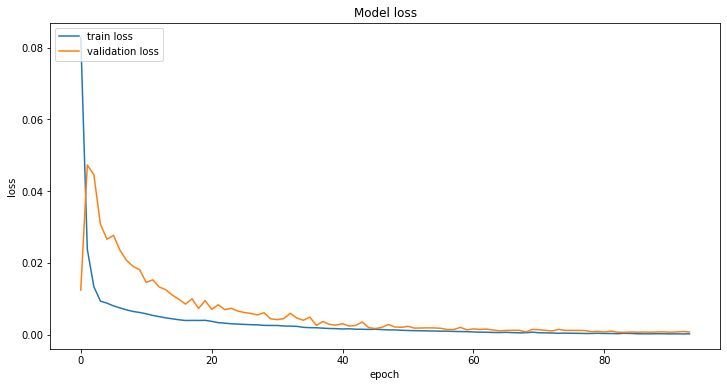

In [16]:
#Plot the evolution of the training and validation loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [17]:
#Calculate the original values for trainY
trainY_Original = scaler_DFF.inverse_transform(trainY)

In [18]:
#Make predictions
trainPredict_1 = model_1.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_1 = scaler_DFF.inverse_transform(trainPredict_1)

#Print evaluation metrics
model_evualuation_metrics(trainY_Original, trainPredict_1)

Model MAE: 0.26
Model MSE: 0.13
Model RMSE: 0.36
Model R2: 0.99


### **2.4 Model_2**

In [19]:
#Model_2 components
model_2 =Sequential()
model_2.add(LSTM(50, activation="relu", return_sequences=True))
model_2.add(LSTM(50, activation="relu"))
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer="adam")

In [20]:
#Fit the model_2 applying same call bancks
history_2 = model_2.fit(trainX, 
                        trainY, 
                        validation_split=0.3, 
                        epochs=200, 
                        batch_size=64, 
                        verbose=1, 
                        callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/200
9/9 [==============================] - 3s 81ms/step - loss: 0.1098 - val_loss: 0.0093 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 0s 25ms/step - loss: 0.0550 - val_loss: 0.0479 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0190 - val_loss: 0.0696 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 0s 31ms/step - loss: 0.0127 - val_loss: 0.0391 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0111 - val_loss: 0.0329 - lr: 0.0010
Epoch 6/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0091 - val_loss: 0.0262 - lr: 0.0010
Epoch 7/200
9/9 [==============================] - 0s 33ms/step - loss: 0.0076 - val_loss: 0.0189 - lr: 0.0010
Epoch 8/200
9/9 [==============================] - 0s 44ms/step - loss: 0.0069 - val_loss: 0.0134 - lr: 0.0010
Epoch 9/200
9/9 [==============================] - 0s 39ms/step - loss: 0.0064 - val_loss: 0.0134 - lr: 0.0010
E

In [21]:
#Print model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 50)            10800     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


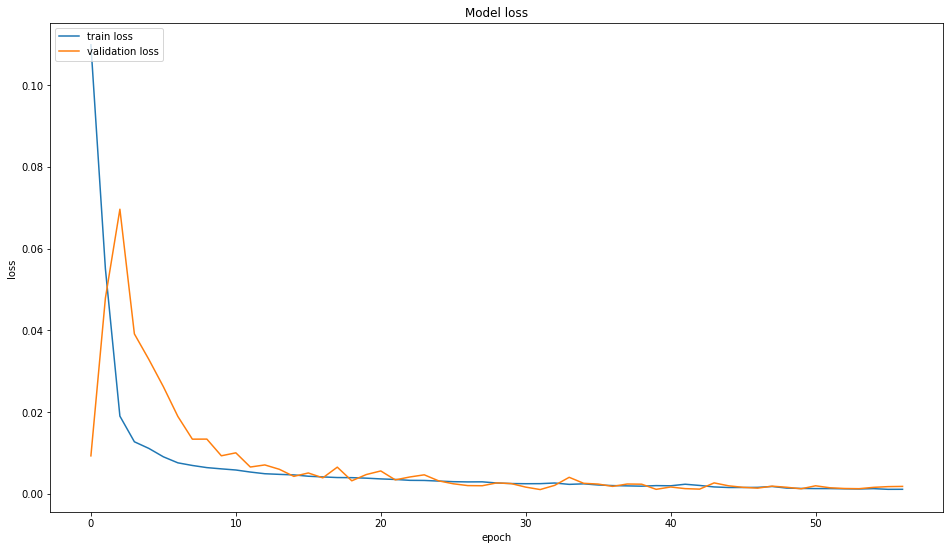

In [22]:
#Plot the evolution of the training and validation loss
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [23]:
#Make predictions
trainPredict_2 = model_2.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_2 = scaler_DFF.inverse_transform(trainPredict_2)

#Print evaluation metrics
model_evualuation_metrics(trainY_Original, trainPredict_2)

Model MAE: 0.48
Model MSE: 0.46
Model RMSE: 0.68
Model R2: 0.97


### **2.5 Model_3**

In [24]:
#Model_3 components
model_3 =Sequential()
model_3.add(LSTM(50, activation="relu", return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(50, activation="relu"))
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer="adam")

In [25]:
#Fit the model_3 applying same call bancks
history_3 = model_3.fit(trainX, 
                        trainY, 
                        validation_split=0.3, 
                        epochs=200, 
                        batch_size=64, 
                        verbose=1, 
                        callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/200
9/9 [==============================] - 3s 75ms/step - loss: 0.1356 - val_loss: 0.0045 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 0s 25ms/step - loss: 0.0368 - val_loss: 0.0231 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 0s 24ms/step - loss: 0.0132 - val_loss: 0.0304 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0079 - val_loss: 0.0196 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0083 - val_loss: 0.0213 - lr: 0.0010
Epoch 6/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0074 - val_loss: 0.0220 - lr: 0.0010
Epoch 7/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0066 - val_loss: 0.0155 - lr: 0.0010
Epoch 8/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0061 - val_loss: 0.0148 - lr: 0.0010
Epoch 9/200
9/9 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0110 - lr: 0.0010
E

In [26]:
#Print model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 50)            10800     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


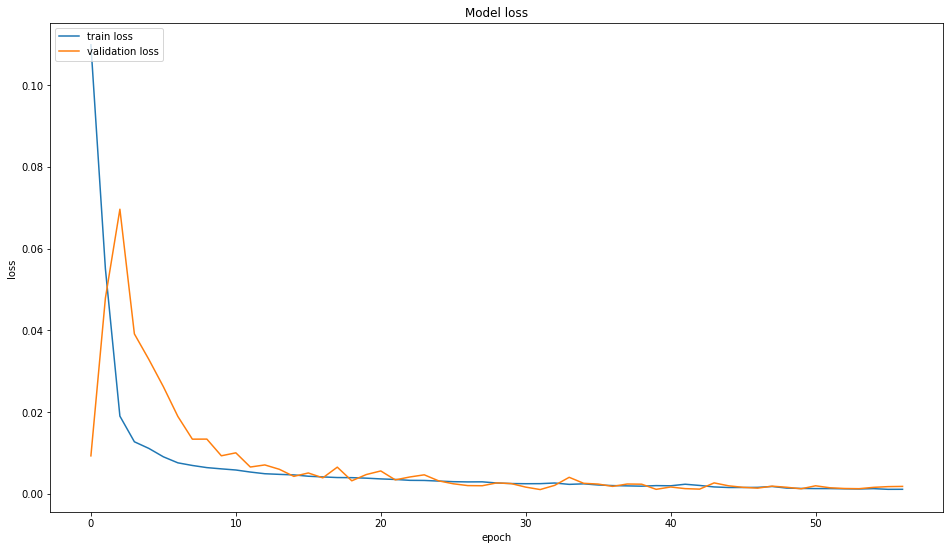

In [27]:
#Plot the evolution of the training and validation loss
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [28]:
#Make predictions
trainPredict_3 = model_3.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_3 = scaler_DFF.inverse_transform(trainPredict_3)

#Print evaluation metrics
model_evualuation_metrics(trainY_Original, trainPredict_3)

Model MAE: 0.51
Model MSE: 0.47
Model RMSE: 0.68
Model R2: 0.97


### **2.6 Visualizing results** 

In [29]:
#Convert predictions into DataFrames
df_trainY = pd.DataFrame(trainY_Original, columns = ["DFF_Original"])
df_trainPredict_1 = pd.DataFrame(trainPredict_1, columns = ["DFF_pred_1"])
df_trainPredict_2 = pd.DataFrame(trainPredict_2, columns = ["DFF_pred_2"])
df_trainPredict_3 = pd.DataFrame(trainPredict_3, columns = ["DFF_pred_3"])

#Combine original and predicted values
Train_comp = pd.concat([df_trainY, df_trainPredict_1, df_trainPredict_2, df_trainPredict_3], axis=1)

#Add the dates to original and predicted values dataframe
Train_comp["Date"] = train_dates
Train_comp.set_index("Date", inplace=True)

Train_comp

,DFF_Original,DFF_pred_1,DFF_pred_2,DFF_pred_3
Date,,,,
1959-01-01,2.42,2.283479,1.919236,2.100108
1959-02-01,2.48,2.421788,2.241746,2.304833
1959-03-01,2.43,2.474118,2.465757,2.475191
1959-04-01,2.80,2.590818,2.670787,2.663243
1959-05-01,2.96,2.762767,2.846862,2.860195
...,...,...,...,...
2021-02-01,0.09,0.960279,1.460106,1.316123
2021-03-01,0.08,0.994544,1.716869,1.498713
2021-04-01,0.07,1.079674,1.875381,1.623367


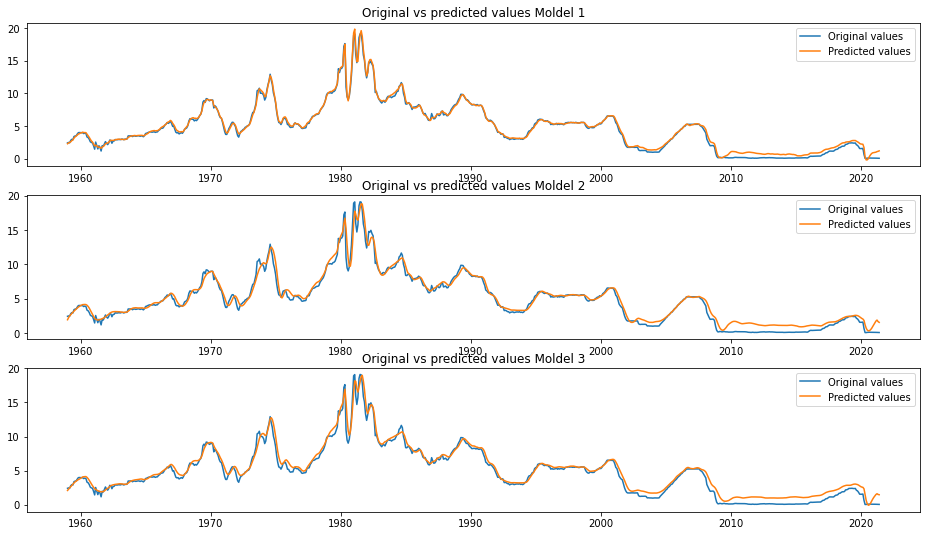

In [30]:
#Plot in sample prediction for the three models 
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(Train_comp.DFF_Original, label= "Original values")
ax1.plot(Train_comp.DFF_pred_1, label = "Predicted values")
ax1.set_title("Original vs predicted values Moldel 1")
ax1.legend(loc="best")

ax2.plot(Train_comp.DFF_Original, label= "Original values")
ax2.plot(Train_comp.DFF_pred_2, label = "Predicted values")
ax2.set_title("Original vs predicted values Moldel 2")
ax2.legend(loc="best")

ax3.plot(Train_comp.DFF_Original, label= "Original values")
ax3.plot(Train_comp.DFF_pred_3, label = "Predicted values")
ax3.set_title("Original vs predicted values Moldel 3")
ax3.legend(loc="best")

# **3. Multi-step forecast**

### **3.1 Preprocesing data**

In [31]:
#Sequence adjustment parameters
sliding_window = 12
forecast_values = 12
n_features = 3

In [32]:
#Create X and Y train data sets
trainX, trainY = TS_LST_Multivarite_prep(final_np_scaled, sliding_window, forecast_values)

#Check the shape of trainX and trainY
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (739, 12, 3).
trainY shape == (739, 12).


### **3.2 Multivariate model multi-step forecast**

In [33]:
#Model_1 components
model_1_MSforecast =Sequential()
model_1_MSforecast.add(LSTM(50, activation="relu"))
model_1_MSforecast.add(Dense(forecast_values))
model_1_MSforecast.compile(loss='mean_squared_error', optimizer="adam")

In [34]:
#Fit the model_2 applying same call bancks
history_1 = model_1_MSforecast.fit(trainX, 
                                   trainY, 
                                   validation_split=0.3, 
                                   epochs=100, 
                                   batch_size=64, 
                                   verbose=1, 
                                   callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
9/9 [==============================] - 2s 42ms/step - loss: 0.1248 - val_loss: 0.0091 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0928 - val_loss: 0.0103 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0572 - val_loss: 0.0249 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0308 - val_loss: 0.0401 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0183 - val_loss: 0.0302 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0144 - val_loss: 0.0308 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0126 - val_loss: 0.0289 - lr: 0.0010
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0122 - val_loss: 0.0275 - lr: 0.0010
Epoch 9/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0118 - val_loss: 0.0276 - lr: 0.0010
E

In [35]:
#Print model summary
model_1_MSforecast.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10800     
                                                                 
 dense_3 (Dense)             (None, 12)                612       
                                                                 
Total params: 11,412
Trainable params: 11,412
Non-trainable params: 0
_________________________________________________________________


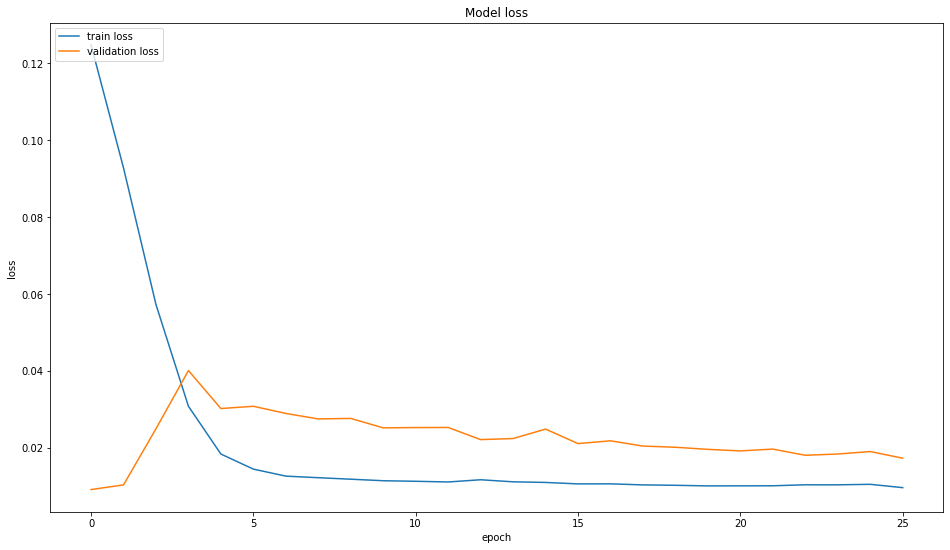

In [36]:
#Plot the evolution of the training and validation loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [37]:
#Make predictions
trainPredict_1 = model_1_MSforecast.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_1 = scaler_DFF.inverse_transform(trainPredict_1)

#Print evaluation metrics
model_evualuation_metrics(trainY, trainPredict_1)

Model MAE: 5.23
Model MSE: 32.48
Model RMSE: 5.70
Model R2: -876.75


### **3.3 Prediction validation data**

In [38]:
#Get the last 12 values for the training set to predict validation data
initial_data = final_np_scaled[-sliding_window:]
initial_data = initial_data.reshape(1, sliding_window, 3) #Reshap

In [39]:
#Make predictions
trainPredict_1_MSforecast = model_1_MSforecast.predict(initial_data)

#Escale-back the values to compared them agains the original values
prediction_new_MultiStep = scaler_DFF.inverse_transform(trainPredict_1_MSforecast)

In [40]:
#Convine predicted and original validation values
df_trainY_val_MultiStep = prediction_new_MultiStep.ravel()
df_validation.insert(1, "DFF_Pred_MUltiStep", df_trainY_val_MultiStep)
df_validation

,DFF,DFF_Pred_MUltiStep,UNRATE,CPIU
DATE,,,,
2021-07-01,0.10,2.750732,5.4,5.37
2021-08-01,0.09,3.097193,5.2,5.25
2021-09-01,0.08,2.801743,4.7,5.39
2021-10-01,0.08,2.474051,4.6,6.22
2021-11-01,0.08,3.360018,4.2,6.81
2021-12-01,0.08,3.552549,3.9,7.04
2022-01-01,0.08,4.313427,4.0,7.48
2022-02-01,0.08,3.548975,3.8,7.87
2022-03-01,0.20,3.731188,3.6,8.54


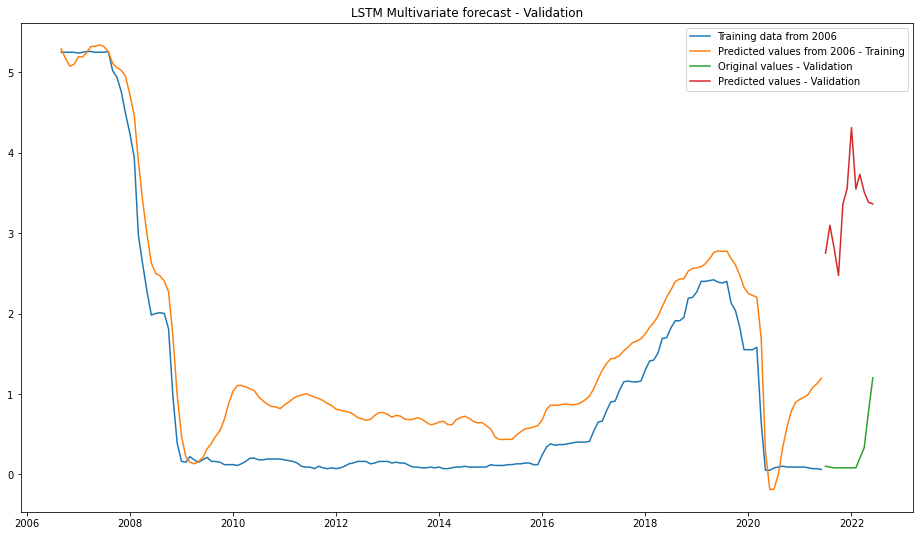

In [41]:
#Plot validation values and original data from 1996
plt.plot(Train_comp.DFF_Original[572:], label= "Training data from 2006")
plt.plot(Train_comp.DFF_pred_1[572:], label = "Predicted values from 2006 - Training")
plt.plot(df_validation.DFF, label= "Original values - Validation")
plt.plot(df_validation.DFF_Pred_MUltiStep, label = "Predicted values - Validation")
plt.title("LSTM Multivariate forecast - Validation")
plt.legend(loc="best")
plt.show()

In [42]:
#Print evaluation metrics
model_evualuation_metrics(df_validation.DFF, df_validation.DFF_Pred_MUltiStep)

Model MAE: 3.06
Model MSE: 9.67
Model RMSE: 3.11
Model R2: -81.87


#**4. Forecast using 7 months lagged predictor**

## **4.1 Preprocessing data**

In [43]:
#Select DFF and CPIU
final_df = final_df.loc[:, ["DFF", "UNRATE", "CPIU"]]
final_df

,DFF,UNRATE,CPIU
DATE,,,
1958-01-01,2.72,5.8,3.62
1958-02-01,1.67,6.4,3.25
1958-03-01,1.20,6.7,3.60
1958-04-01,1.26,7.4,3.58
1958-05-01,0.63,7.4,3.21
...,...,...,...
2022-02-01,0.08,3.8,7.87
2022-03-01,0.20,3.6,8.54
2022-04-01,0.33,3.6,8.26


In [44]:
#Convert the DFF column into a np array and remove the last 7 values
DFF_Adj_7M = final_df["DFF"].values
DFF_Adj_7M = DFF_Adj_7M[:-7]

#Remove the first 7 observations of final_df_7M
final_df_7M_Adj = final_df.iloc[7:]
final_df_7M_Adj = final_df_7M_Adj.drop(columns=["DFF"])
final_df_7M_Adj

#Combine1 predicted and original validation values
final_df_7M_Adj.insert(0, "DFF", DFF_Adj_7M)
final_df_7M_Adj

,DFF,UNRATE,CPIU
DATE,,,
1958-08-01,2.72,7.4,2.12
1958-09-01,1.67,7.1,2.12
1958-10-01,1.20,6.7,2.12
1958-11-01,1.26,6.2,2.11
1958-12-01,0.63,6.2,1.76
...,...,...,...
2022-02-01,0.10,3.8,7.87
2022-03-01,0.09,3.6,8.54
2022-04-01,0.08,3.6,8.26


In [45]:
#Create training, test and validation partitions for plotting
#Validation set 
df_validation_7M = final_df_7M_Adj.iloc[-12:]

#Remove the 12 observations for validation and split remaining into train and test (70% - 30%)
final_df_7M_Adj = final_df_7M_Adj[:-12]

#Create train and test data sets
train_size = int(len(final_df_7M_Adj) * 0.7)
test_size = len(final_df_7M_Adj) - train_size
df_train, df_test = final_df_7M_Adj[0:train_size], final_df_7M_Adj[train_size:len(final_df_7M_Adj)]

#Print the shape of train test and validation sets
print("df_train shape is {}".format(df_train.shape))
print("df_test shape is {}".format(df_test.shape))
print("df_validation shape is {}".format(df_validation_7M.shape))

df_train shape is (528, 3)
df_test shape is (227, 3)
df_validation shape is (12, 3)


In [46]:
#Save date for plotting, ignore the first 12 as they are burn predicting the first value
train_dates = pd.to_datetime(final_df_7M_Adj.index[12:774])

#Convert each variable to a numpy array
DFF_val = final_df_7M_Adj["DFF"].values
UNRATED_val = final_df_7M_Adj["UNRATE"].values
CPIU_val = final_df_7M_Adj["CPIU"].values

#Reshape the structure of the numpy arrays to (rows, columns)
DFF_val = DFF_val.reshape((len(DFF_val), 1))
UNRATED_val = UNRATED_val.reshape((len(UNRATED_val), 1))
CPIU_val = CPIU_val.reshape((len(CPIU_val), 1))

#Check the shape of the previous three variables
print("DFF_val shape is {}.".format(DFF_val.shape))
print("UNRATED_val shape is {}.".format(UNRATED_val.shape))
print("CPIU_val shape is {}".format(CPIU_val.shape))

DFF_val shape is (755, 1).
UNRATED_val shape is (755, 1).
CPIU_val shape is (755, 1)


In [47]:
#Scale variables individually

#Apply StandardScaler to escale the data between 0 and 1 
scaler_DFF = MinMaxScaler()
DFF_scaled = scaler_DFF.fit_transform(DFF_val)

scaler_UNRATED = MinMaxScaler()
UNRATED_scaled = scaler_UNRATED.fit_transform(UNRATED_val)

scaler_CPIU = MinMaxScaler()
CPIU_scaled = scaler_CPIU.fit_transform(CPIU_val)

#Combine the three numpy arrays
final_np_scaled = np.hstack((DFF_scaled, UNRATED_scaled, CPIU_scaled))
print("final_np_scaled shape == {}".format(final_np_scaled.shape))

final_np_scaled shape == (755, 3)


In [48]:
#Sequence adjustment parameters
sliding_window = 12
forecast_values = 12
n_features = 3

In [49]:
#Create X and Y train data sets
trainX, trainY = TS_LST_Multivarite_prep(final_np_scaled, sliding_window, forecast_values)

#Check the shape of trainX and trainY
print('trainX shape is {}.'.format(trainX.shape))
print('trainY shape is {}.'.format(trainY.shape))

trainX shape is (732, 12, 3).
trainY shape is (732, 12).


## **4.2 Multivariate model multi-step forecast**

In [50]:
#Model_1 components
model_1_MSforecast =Sequential()
model_1_MSforecast.add(LSTM(50, activation="relu"))
model_1_MSforecast.add(Dense(forecast_values))
model_1_MSforecast.compile(loss='mean_squared_error', optimizer="adam")

In [51]:
#Fit the model_2 applying same call bancks
history_1 = model_1_MSforecast.fit(trainX, 
                                   trainY, 
                                   validation_split=0.3, 
                                   epochs=100, 
                                   batch_size=64, 
                                   verbose=1, 
                                   callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
8/8 [==============================] - 2s 66ms/step - loss: 0.1324 - val_loss: 0.0095 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1062 - val_loss: 0.0092 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0719 - val_loss: 0.0190 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0369 - val_loss: 0.0554 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0220 - val_loss: 0.0400 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0147 - val_loss: 0.0360 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.0397 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0121 - val_loss: 0.0331 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0303 - lr: 0.0010
E

In [52]:
#Print model summary
model_1_MSforecast.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10800     
                                                                 
 dense_4 (Dense)             (None, 12)                612       
                                                                 
Total params: 11,412
Trainable params: 11,412
Non-trainable params: 0
_________________________________________________________________


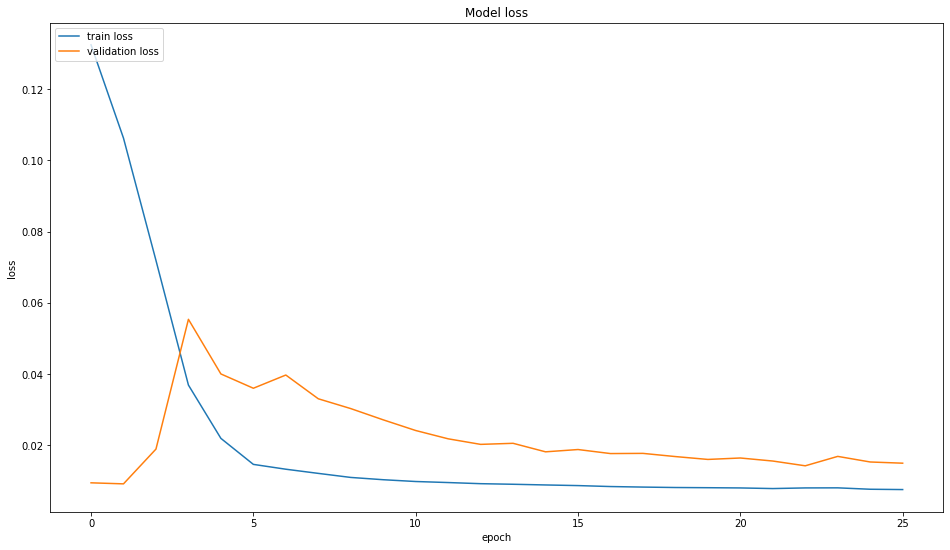

In [53]:
#Plot the evolution of the training and validation loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

 ## **4.3 Predict on validation data**

In [54]:
#Get the last 12 values for the training set to predict validation data
initial_data = final_np_scaled[-sliding_window:]
initial_data = initial_data.reshape(1, sliding_window, 3) #Reshap

In [55]:
#Make predictions
trainPredict_1_MSforecast = model_1_MSforecast.predict(initial_data)

#Escale-back the values to compared them agains the original values
prediction_new_MultiStep = scaler_DFF.inverse_transform(trainPredict_1_MSforecast)

In [56]:
#Convine predicted and original validation values
df_trainY_val_MultiStep = prediction_new_MultiStep.ravel()
df_validation_7M.insert(1, "DFF_Pred_MUltiStep", df_trainY_val_MultiStep)
df_validation_7M

,DFF,DFF_Pred_MUltiStep,UNRATE,CPIU
DATE,,,,
2021-07-01,0.09,2.765464,5.4,5.37
2021-08-01,0.09,3.156976,5.2,5.25
2021-09-01,0.08,2.413485,4.7,5.39
2021-10-01,0.07,3.156282,4.6,6.22
2021-11-01,0.07,2.534174,4.2,6.81
2021-12-01,0.06,3.282280,3.9,7.04
2022-01-01,0.08,2.621210,4.0,7.48
2022-02-01,0.10,2.868590,3.8,7.87
2022-03-01,0.09,3.185435,3.6,8.54


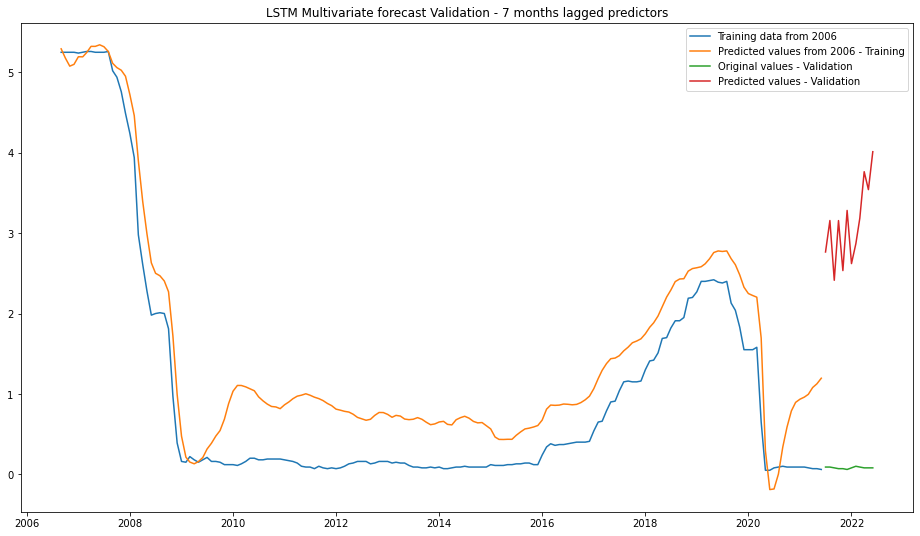

In [57]:
#Plot validation values and original data from 2006
plt.plot(Train_comp.DFF_Original[572:], label= "Training data from 2006")
plt.plot(Train_comp.DFF_pred_1[572:], label = "Predicted values from 2006 - Training")
plt.plot(df_validation_7M.DFF, label= "Original values - Validation")
plt.plot(df_validation_7M.DFF_Pred_MUltiStep, label = "Predicted values - Validation")
plt.title("LSTM Multivariate forecast Validation - 7 months lagged predictors")
plt.legend(loc="best")
plt.show()

In [58]:
#Print evaluation metrics
Org_values = df_validation.DFF.values
Pred_values = df_validation.DFF_Pred_MUltiStep.values

model_evualuation_metrics(Org_values, Pred_values)

Model MAE: 3.06
Model MSE: 9.67
Model RMSE: 3.11
Model R2: -81.87


# **5. Forecast using CPIU 7 months lagged as only response variable**

## **5.1 Preprocesing data**

In [59]:
#Select DFF and CPIU
final_df_CPIU = final_df.loc[:, ["DFF", "CPIU"]]
final_df_CPIU

,DFF,CPIU
DATE,,
1958-01-01,2.72,3.62
1958-02-01,1.67,3.25
1958-03-01,1.20,3.60
1958-04-01,1.26,3.58
1958-05-01,0.63,3.21
...,...,...
2022-02-01,0.08,7.87
2022-03-01,0.20,8.54
2022-04-01,0.33,8.26


In [60]:
#Convert the DFF column into a np array and remove the last 6 values
DFF_Adj = final_df_CPIU["DFF"].values
DFF_Adj = DFF_Adj[:-7]

#Remove the first 6 observations of final_df
final_df_7M_CPIU = final_df_CPIU.iloc[7:]
final_df_7M_CPIU = final_df_7M_CPIU.drop(columns=["DFF"])
final_df_7M_CPIU

#Convine predicted and original validation values
final_df_7M_CPIU.insert(0, "DFF", DFF_Adj)
final_df_7M_CPIU

,DFF,CPIU
DATE,,
1958-08-01,2.72,2.12
1958-09-01,1.67,2.12
1958-10-01,1.20,2.12
1958-11-01,1.26,2.11
1958-12-01,0.63,1.76
...,...,...
2022-02-01,0.10,7.87
2022-03-01,0.09,8.54
2022-04-01,0.08,8.26


In [61]:
#Create training, test and validation partitions for plotting
#Validation set 
df_validation_7M_CPIU = final_df_7M_CPIU.iloc[-12:]

#Remove the 12 observations for validation and split remaining into train and test (70% - 30%)
final_df_7M_CPIU = final_df_7M_CPIU[:-12]

#Create train and test data sets
train_size = int(len(final_df_7M_CPIU) * 0.7)
test_size = len(final_df_7M_CPIU) - train_size
df_train, df_test = final_df_7M_CPIU[0:train_size], final_df_7M_CPIU[train_size:len(final_df_7M_CPIU)]

#Print the shape of train test and validation sets
print("df_train shape is {}".format(df_train.shape))
print("df_test shape is {}".format(df_test.shape))
print("df_validation shape is {}".format(df_validation_7M.shape))

df_train shape is (528, 2)
df_test shape is (227, 2)
df_validation shape is (12, 4)


In [62]:
#Save date for plotting, ignore the first 12 as they are burn predicting the first value
train_dates = pd.to_datetime(final_df_7M_CPIU.index[12:774])

#Convert each variable to a numpy array
DFF_val = final_df_7M_CPIU["DFF"].values
CPIU_val = final_df_7M_CPIU["CPIU"].values

#Reshape the structure of the numpy arrays to (rows, columns)
DFF_val = DFF_val.reshape((len(DFF_val), 1))
CPIU_val = CPIU_val.reshape((len(CPIU_val), 1))

#Check the shape of the previous three variables
print("DFF_val shape is {}.".format(DFF_val.shape))
print("CPIU_val shape is {}".format(CPIU_val.shape))

DFF_val shape is (755, 1).
CPIU_val shape is (755, 1)


In [63]:
#Scale variables individually

#Apply StandardScaler to escale the data between 0 and 1 
scaler_DFF = MinMaxScaler()
DFF_scaled = scaler_DFF.fit_transform(DFF_val)

scaler_CPIU = MinMaxScaler()
CPIU_scaled = scaler_CPIU.fit_transform(CPIU_val)

#Combine the three numpy arrays
final_np_scaled = np.hstack((DFF_scaled, CPIU_scaled))
print("final_np_scaled shape == {}".format(final_np_scaled.shape))

final_np_scaled shape == (755, 2)


In [64]:
#Sequence adjustment parameters
sliding_window = 12
forecast_values = 12
n_features = 3

In [65]:
#Create X and Y train data sets
trainX, trainY = TS_LST_Multivarite_prep(final_np_scaled, sliding_window, forecast_values)

#Check the shape of trainX and trainY
print('trainX shape is {}.'.format(trainX.shape))
print('trainY shape is {}.'.format(trainY.shape))

trainX shape is (732, 12, 2).
trainY shape is (732, 12).


## **5.2 Multivariate model multi-step forecast**

In [66]:
#Model_1 components
model_1_MSforecast =Sequential()
model_1_MSforecast.add(LSTM(50, activation="relu"))
model_1_MSforecast.add(Dense(forecast_values))
model_1_MSforecast.compile(loss='mean_squared_error', optimizer="adam")

In [67]:
#Fit the model_2 applying same call bancks
history_1 = model_1_MSforecast.fit(trainX, 
                                   trainY, 
                                   validation_split=0.3, 
                                   epochs=100, 
                                   batch_size=64, 
                                   verbose=1, 
                                   callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
8/8 [==============================] - 2s 64ms/step - loss: 0.1335 - val_loss: 0.0093 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1161 - val_loss: 0.0075 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0960 - val_loss: 0.0070 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0690 - val_loss: 0.0122 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0341 - val_loss: 0.0403 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0215 - val_loss: 0.0304 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0139 - val_loss: 0.0282 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0335 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 0.0278 - lr: 0.0010
E

In [68]:
#Print model summary
model_1_MSforecast.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                10600     
                                                                 
 dense_5 (Dense)             (None, 12)                612       
                                                                 
Total params: 11,212
Trainable params: 11,212
Non-trainable params: 0
_________________________________________________________________


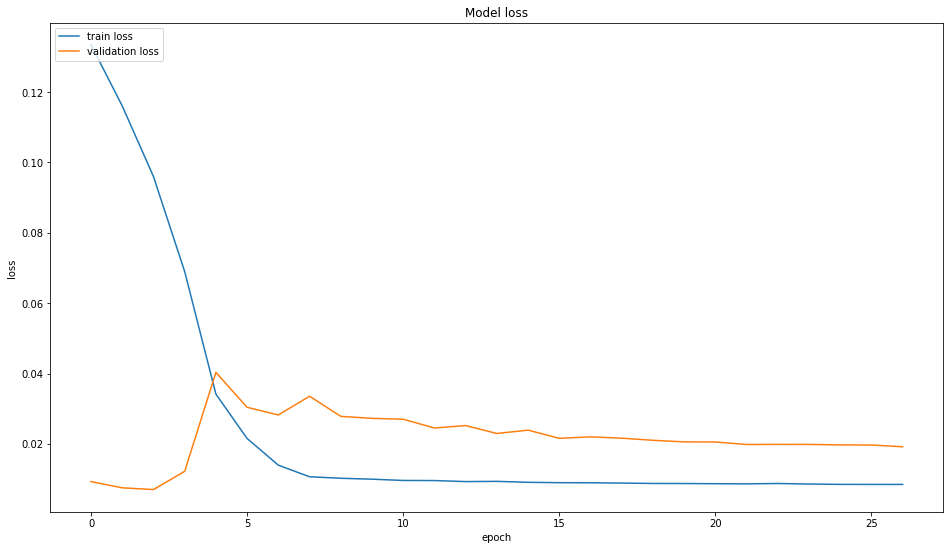

In [69]:
#Plot the evolution of the training and validation loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

## **5.3 Predict on validation data**

In [70]:
#Get the last 12 values for the training set to predict validation data
initial_data = final_np_scaled[-sliding_window:]
initial_data = initial_data.reshape(1, sliding_window, 2) #Reshap

In [71]:
#Make predictions
trainPredict_1_MSforecast = model_1_MSforecast.predict(initial_data)

#Escale-back the values to compared them agains the original values
prediction_new_MultiStep = scaler_DFF.inverse_transform(trainPredict_1_MSforecast)

In [72]:
#Convine predicted and original validation values
df_trainY_val_MultiStep = prediction_new_MultiStep.ravel()
df_validation_7M_CPIU.insert(1, "DFF_Pred_MUltiStep", df_trainY_val_MultiStep)
df_validation_7M_CPIU

,DFF,DFF_Pred_MUltiStep,CPIU
DATE,,,
2021-07-01,0.09,2.975843,5.37
2021-08-01,0.09,3.497589,5.25
2021-09-01,0.08,3.945562,5.39
2021-10-01,0.07,3.396968,6.22
2021-11-01,0.07,3.103632,6.81
2021-12-01,0.06,3.179813,7.04
2022-01-01,0.08,3.418643,7.48
2022-02-01,0.10,4.064029,7.87
2022-03-01,0.09,3.722569,8.54


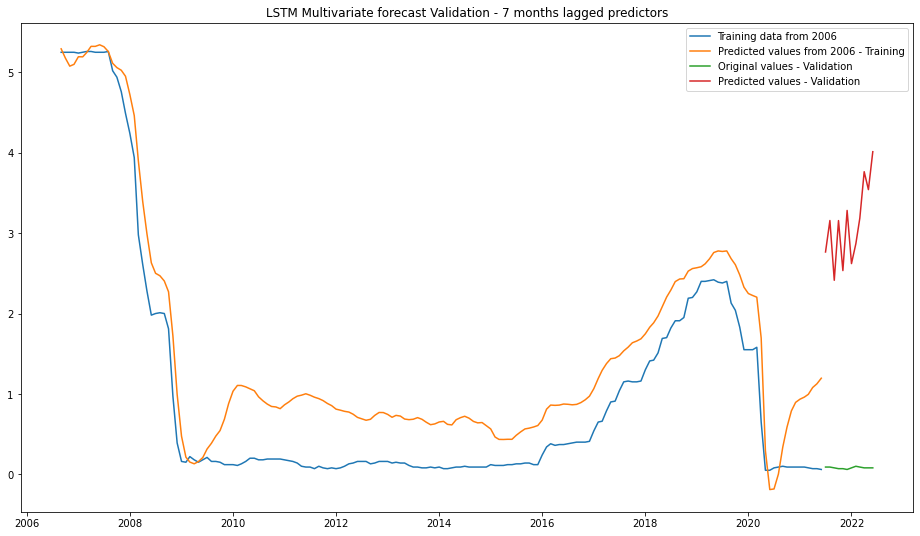

In [73]:
#Plot validation values and original data from 2006
plt.plot(Train_comp.DFF_Original[572:], label= "Training data from 2006")
plt.plot(Train_comp.DFF_pred_1[572:], label = "Predicted values from 2006 - Training")
plt.plot(df_validation_7M.DFF, label= "Original values - Validation")
plt.plot(df_validation_7M.DFF_Pred_MUltiStep, label = "Predicted values - Validation")
plt.title("LSTM Multivariate forecast Validation - 7 months lagged predictors")
plt.legend(loc="best")
plt.show()